In [2]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import cv2
from model import *


In [3]:
tf.__version__

'1.14.0'

In [4]:
batch_size = 1
GRU_size = 512
action_dim = 4
learning_rate = 1e-4
demo_length = 30
max_follow_length = 50
memory_dim = 512
EPOCH = 500
img_size = 256
feature_dim = 512

In [5]:
DATA_DIR = 'preprocessed_habitat_data2'

train_list = [os.path.join(DATA_DIR,'train',x) for x in os.listdir(os.path.join(DATA_DIR,'train'))]
valid_list = [os.path.join(DATA_DIR,'valid',x) for x in os.listdir(os.path.join(DATA_DIR,'valid'))]


In [6]:
def load_data(data_path):
    try:
        noise_data = joblib.load(data_path)
        mode = 'train' if 'train' in str(data_path) else 'valid'
        ref_data_name = str(data_path).replace(mode, 'DEMON')
        ref_data_name = ref_data_name[:ref_data_name.find('.dat.gz')-1] + '0.dat.gz'
        ref_data = joblib.load(str(ref_data_name))
        #ref_data = joblib.load(str(ref_data_name))

        noise_rgb  = np.array(noise_data['rgb'],dtype=np.float32)/255.0 * 2 - 1
        ref_rgb = np.array(ref_data['rgb'],dtype=np.float32)/255.0 * 2 - 1

        noise_data['action'] = np.array(noise_data['action'],dtype=np.int8)
        ref_data['action'] = np.array(ref_data['action'],dtype=np.int8)

        a = np.where(noise_data['action']>5)
        b = np.where(ref_data['action']>5)
        noise_data['action'][a] = noise_data['action'][a] - 5
        ref_data['action'][b] = ref_data['action'][b] - 5

        noise_action = np.eye(action_dim)[noise_data['action']]
        ref_action = np.eye(action_dim)[ref_data['action']]

        add_t = max_follow_length - len(noise_rgb)
        if add_t < 0 : 
            noise_rgb = noise_rgb[:max_follow_length]
            noise_action = noise_action[:max_follow_length]
            action_mask = np.ones_like(noise_action)
            action_mask = action_mask[:max_follow_length]
            print('its weird..', data_path)

        else:
            img_size = noise_rgb[0].shape[1]
            action_mask = np.ones_like(noise_action)

            noise_rgb = np.concatenate([noise_rgb, np.zeros([add_t, img_size, img_size, 3])],0)
            noise_action = np.concatenate([noise_action, np.zeros([add_t, action_dim])],0)
            action_mask = np.concatenate([action_mask, np.zeros([add_t, action_dim])],0)

        
    except:
        ref_rgb = np.zeros([30,256,256,3])
        ref_action = np.zeros([30,4])
        noise_rgb = np.zeros([50,256,256,3])
        noise_action = np.zeros([50,4])
        action_mask = np.zeros([50,4])
        
    result = [ref_rgb, ref_action, noise_rgb, noise_action, action_mask]
    return [np.array(x,dtype=np.float32) for x in result]

In [7]:
rpf = RPF()
rpf.batch_size = batch_size
#rpf.build_network_for_train(None,placeholder=True)
rpf.build_network_for_running()


W0730 15:16:10.869221 140106295195392 deprecation_wrapper.py:119] From /home/obin/codes/VisualNavigation/RPF/model.py:169: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 15:16:10.889336 140106295195392 deprecation_wrapper.py:119] From /home/obin/codes/VisualNavigation/RPF/model.py:49: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0730 15:16:10.890924 140106295195392 deprecation_wrapper.py:119] From /home/obin/codes/VisualNavigation/RPF/model.py:55: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0730 15:16:10.918136 140106295195392 deprecation.py:323] From /home/obin/codes/VisualNavigation/RPF/ops.py:46: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0730 15:16:11.047274 140106295195392 deprecation.py:323] From /home/obin/codes/Vis

In [8]:
init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
network_saver = tf.train.Saver(tf.trainable_variables(),max_to_keep=100)
#saver_a = tf.train.Saver([v for v in tf.all_variables() if v.name == "a1:0"])

version_path = 'v3'
if not os.path.exists('models/'+version_path) : os.makedirs('models/'+version_path)
if not os.path.exists('logs/'+version_path) : os.makedirs('logs/'+version_path)

writer = tf.summary.FileWriter('logs/'+version_path)
#if not os.path.exists('images/'+version_path) : os.makedirs('images/'+version_path)
    
sess = tf.Session(config=config)
sess.run(init)
pre_ckpt = tf.train.get_checkpoint_state('../habitat-api/rpf/models/'+version_path)
if pre_ckpt and pre_ckpt.model_checkpoint_path :
    past_ckpt = pre_ckpt.model_checkpoint_path
    #past_ckpt = 'models/v1ep0058step761985'
    network_saver.restore(sess,past_ckpt)
    print("1. Successfully loaded:", past_ckpt)
    ep = int(past_ckpt[past_ckpt.find('ep')+2:past_ckpt.find('ep')+6])
    step = int(past_ckpt[past_ckpt.find('step')+4:past_ckpt.find('step')+8])
else:
    print("1! Could not find old network weights")
    ep = 0
    step = 0

W0730 15:16:16.175988 140106295195392 deprecation.py:323] From /home/obin/codes/VisualNavigation/venv/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


1. Successfully loaded: ../habitat-api/rpf/models/v3/ep0001step007778


In [9]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
def pprint(x, digit=4):
    element = "%"+".{}f ".format(str(digit))
    log_str = ""
    for e in x:
        log_str += element%(e)
    print(log_str)
    return
    

# BUILT FOR TRAINING

W0730 10:53:52.315241 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


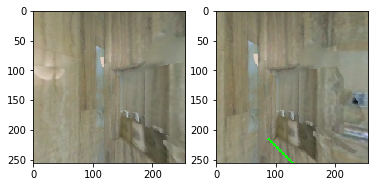

W0730 10:53:52.469964 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


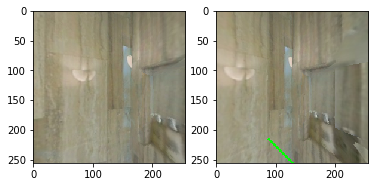

W0730 10:53:52.625970 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


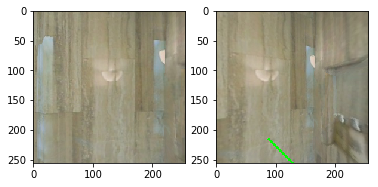

W0730 10:53:52.780882 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


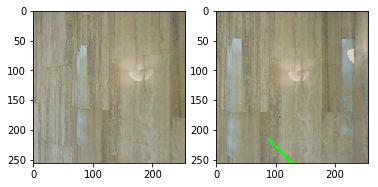

W0730 10:53:52.935009 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


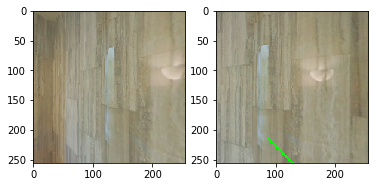

W0730 10:53:53.089515 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


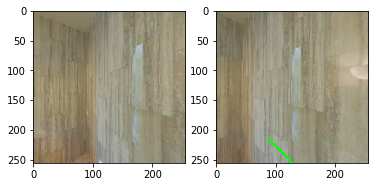

W0730 10:53:53.244660 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


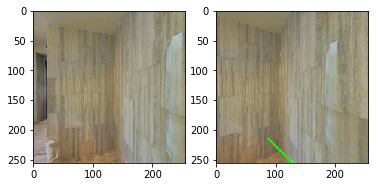

W0730 10:53:53.401042 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


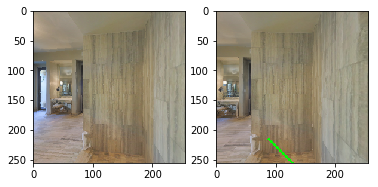

W0730 10:53:53.558670 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


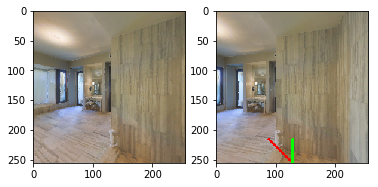

W0730 10:53:53.717318 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


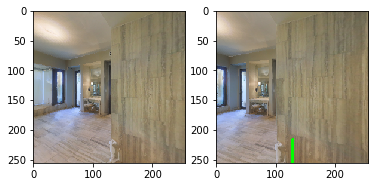

W0730 10:53:53.874906 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


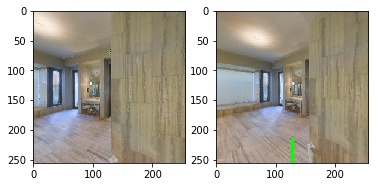

W0730 10:53:54.033303 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


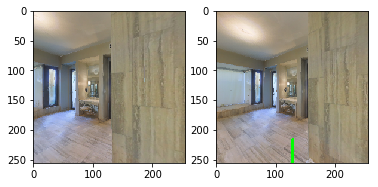

W0730 10:53:54.189924 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


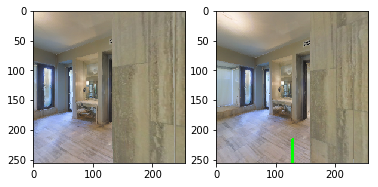

W0730 10:53:54.345436 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


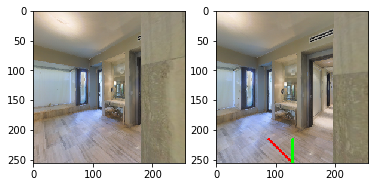

W0730 10:53:54.500696 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


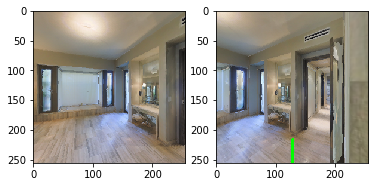

W0730 10:53:54.659161 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


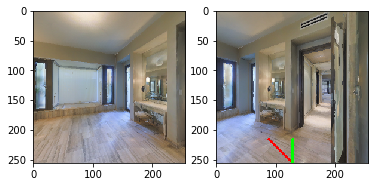

W0730 10:53:54.815011 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


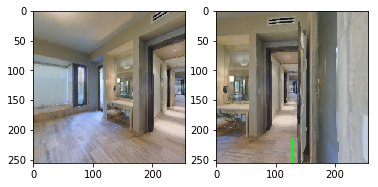

W0730 10:53:54.970567 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


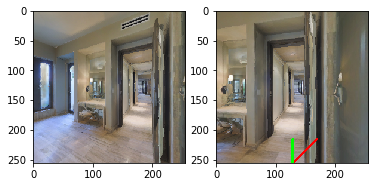

W0730 10:53:55.126744 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


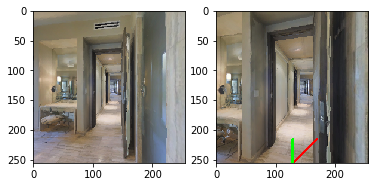

W0730 10:53:55.281506 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


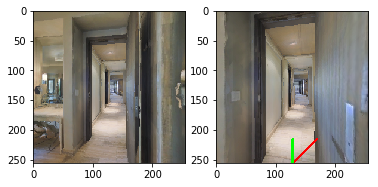

W0730 10:53:55.435912 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


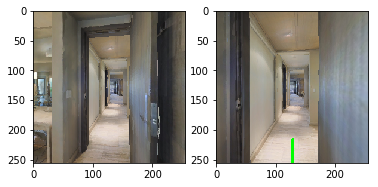

W0730 10:53:55.592473 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


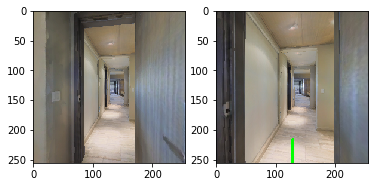

W0730 10:53:55.748242 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


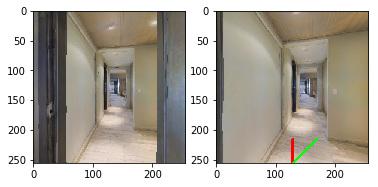

W0730 10:53:55.903342 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


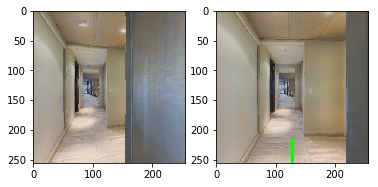

W0730 10:53:56.063633 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


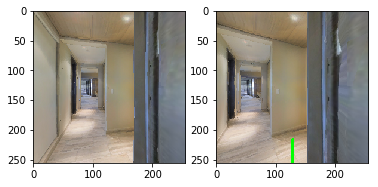

W0730 10:53:56.217539 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


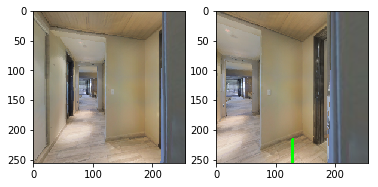

W0730 10:53:56.371818 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


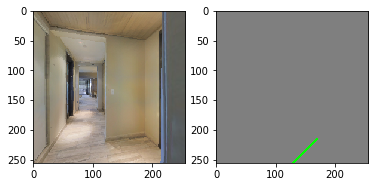

W0730 10:53:56.509238 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


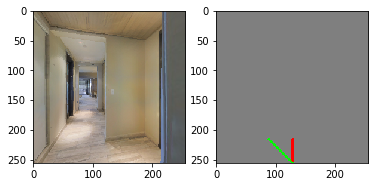

W0730 10:53:56.648505 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


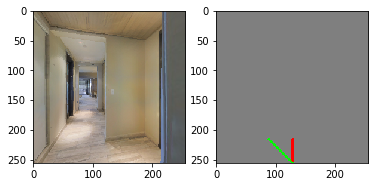

W0730 10:53:56.786042 140426654144256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


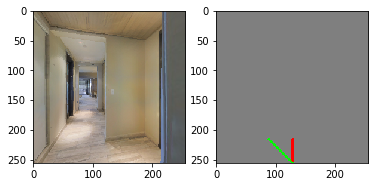

IndexError: index 30 is out of bounds for axis 0 with size 30

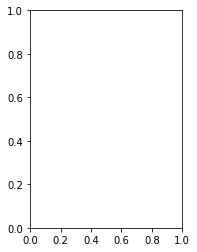

In [53]:
batch = load_data(valid_list[0])
feed = {rpf.demo_seqs_list: np.expand_dims(batch[0],0), 
         rpf.demo_acts_list: np.expand_dims(batch[1],0), 
         rpf.inp_rgb_list:np.expand_dims(batch[2],0), 
         rpf.inp_act_list: np.expand_dims(batch[3],0), 
         rpf.act_loss_mask_list: np.expand_dims(batch[4],0)}
rec = sess.run(rpf.record, feed_dict=feed)
for t in range(max_follow_length):
    plt.subplot(131)
    demo_img = (batch[0][t]+1)/2.
    plt.imshow(demo_img)
    plt.subplot(132)
    demo_img = (batch[0][int(rec['eta'][t].squeeze())]+1)/2.
    ref_act = batch[1][t]
    if np.argmax(ref_act) == 1 : d_angle = 0 
    elif np.argmax(ref_act)== 2 : d_angle = 1
    elif np.argmax(ref_act)== 3 : d_angle = -1
    else : d_angle = 0

    plt.imshow(demo_img)
    
    follow_img = (batch[2][t]+1)/2.
    fol_act = softmax(rec['actions_t'][t].squeeze())
    if np.argmax(fol_act) == 1 : f_angle = 0 
    elif np.argmax(fol_act)== 2 : f_angle = 1
    elif np.argmax(fol_act)== 3 : f_angle = -1
    else : d_angle = 0
    cv2.line(follow_img,(128,256),(int(128-40*d_angle),256-40),(255,0,0),3)
    cv2.line(follow_img,(128,256),(int(128-40*f_angle),256-40),(0,255,0),3)
                      
    plt.subplot(133)
    plt.imshow(follow_img)
    plt.show()
    
    print('eta : ', int(rec['eta'][t].squeeze()))
    pprint(ref_act)
    pprint(fol_act)
    

# BUILT FOR RUNNING

In [10]:
rpf.sess = sess

W0730 14:08:41.418134 140011433498368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


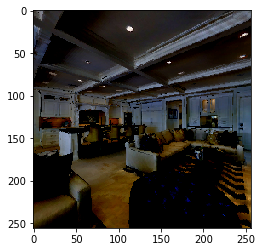

In [12]:
plt.imshow(batch[2][stop]) and plt.show()

In [10]:
print(rpf.curr_eta)

[[29.]]


Memory based on demonstration encoded - saved in RPF


W0730 15:16:25.754236 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


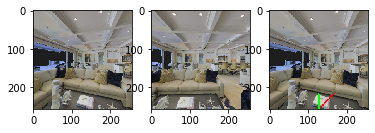

W0730 15:16:26.000473 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  1
0.0000 0.0000 0.0000 1.0000 
0.0000 1.0000 0.0000 0.0000 
0.1554 0.4224 0.8709 0.3204 0.1179 0.0434 0.0160 0.0059 0.0022 0.0008 0.0003 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 


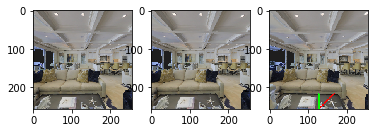

eta :  2
0.0000 0.0000 0.0000 1.0000 
0.0000 1.0000 0.0000 0.0000 
0.0531 0.1443 0.3924 0.9376 0.3449 0.1269 0.0467 0.0172 0.0063 0.0023 0.0009 0.0003 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 


W0730 15:16:26.204780 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


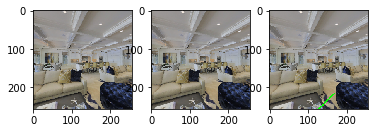

eta :  4
0.0000 0.0000 0.0000 1.0000 
0.0000 0.0000 0.0000 1.0000 
0.0166 0.0452 0.1230 0.3342 0.9086 0.4049 0.1490 0.0548 0.0202 0.0074 0.0027 0.0010 0.0004 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 


W0730 15:16:26.405135 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


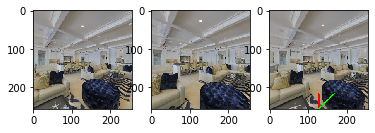

W0730 15:16:26.612244 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  5
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 1.0000 
0.0062 0.0169 0.0460 0.1251 0.3400 0.9241 0.3981 0.1464 0.0539 0.0198 0.0073 0.0027 0.0010 0.0004 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 


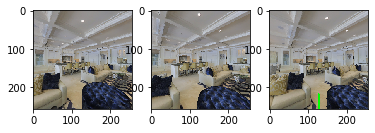

W0730 15:16:26.848684 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  6
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0023 0.0064 0.0173 0.0470 0.1276 0.3470 0.9431 0.3901 0.1435 0.0528 0.0194 0.0071 0.0026 0.0010 0.0004 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 


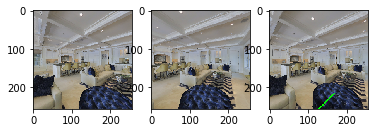

W0730 15:16:27.064373 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  7
0.0000 0.0000 0.0000 1.0000 
0.0000 0.0000 0.0000 1.0000 
0.0008 0.0022 0.0059 0.0162 0.0439 0.1194 0.3245 0.8820 0.4171 0.1534 0.0564 0.0208 0.0076 0.0028 0.0010 0.0004 0.0001 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 


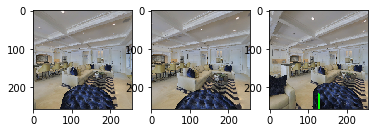

W0730 15:16:27.277795 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  8
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0003 0.0008 0.0021 0.0058 0.0158 0.0428 0.1164 0.3165 0.8603 0.4276 0.1573 0.0579 0.0213 0.0078 0.0029 0.0011 0.0004 0.0001 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 


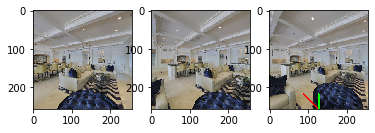

W0730 15:16:27.499025 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  9
0.0000 0.0000 1.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0001 0.0003 0.0007 0.0020 0.0055 0.0149 0.0405 0.1101 0.2993 0.8137 0.4521 0.1663 0.0612 0.0225 0.0083 0.0030 0.0011 0.0004 0.0002 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 


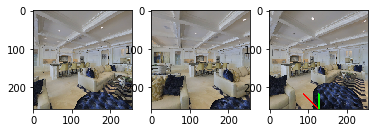

W0730 15:16:27.712418 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  10
0.0000 0.0000 1.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0001 0.0002 0.0006 0.0017 0.0047 0.0127 0.0346 0.0941 0.2559 0.6956 0.5289 0.1946 0.0716 0.0263 0.0097 0.0036 0.0013 0.0005 0.0002 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 


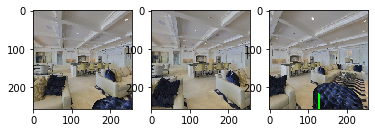

W0730 15:16:27.935396 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  11
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0001 0.0002 0.0006 0.0015 0.0041 0.0111 0.0302 0.0820 0.2229 0.6058 0.6073 0.2234 0.0822 0.0302 0.0111 0.0041 0.0015 0.0006 0.0002 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 


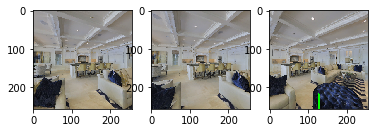

W0730 15:16:28.240089 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  12
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0001 0.0002 0.0005 0.0014 0.0037 0.0100 0.0272 0.0738 0.2007 0.5456 0.6743 0.2480 0.0913 0.0336 0.0123 0.0045 0.0017 0.0006 0.0002 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 


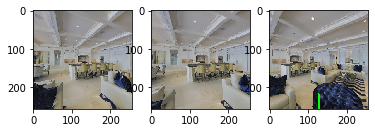

W0730 15:16:28.454506 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  13
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0001 0.0002 0.0005 0.0013 0.0035 0.0094 0.0257 0.0698 0.1897 0.5156 0.7135 0.2625 0.0966 0.0355 0.0131 0.0048 0.0018 0.0007 0.0002 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 


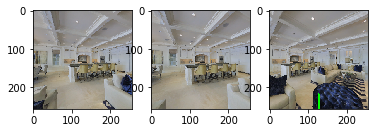

W0730 15:16:28.665096 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  14
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0002 0.0004 0.0012 0.0033 0.0089 0.0242 0.0657 0.1786 0.4856 0.7576 0.2787 0.1025 0.0377 0.0139 0.0051 0.0019 0.0007 0.0003 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 


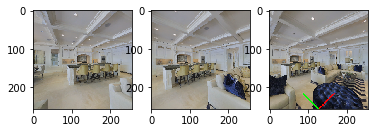

W0730 15:16:28.881216 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  15
0.0000 0.0000 0.0000 1.0000 
0.0000 0.0000 1.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0002 0.0004 0.0011 0.0031 0.0083 0.0226 0.0615 0.1671 0.4542 0.8099 0.2980 0.1096 0.0403 0.0148 0.0055 0.0020 0.0007 0.0003 0.0001 0.0000 0.0000 0.0000 0.0000 


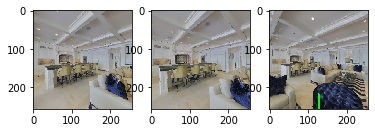

W0730 15:16:29.099584 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  16
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0002 0.0004 0.0011 0.0030 0.0082 0.0223 0.0607 0.1651 0.4487 0.8199 0.3016 0.1110 0.0408 0.0150 0.0055 0.0020 0.0007 0.0003 0.0001 0.0000 0.0000 0.0000 


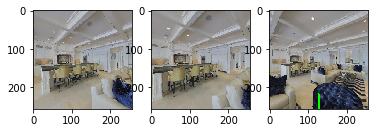

W0730 15:16:29.319210 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  17
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0002 0.0004 0.0011 0.0030 0.0082 0.0224 0.0609 0.1656 0.4501 0.8173 0.3007 0.1106 0.0407 0.0150 0.0055 0.0020 0.0007 0.0003 0.0001 0.0000 0.0000 


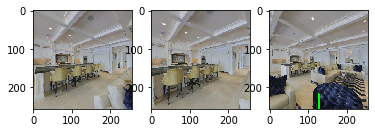

W0730 15:16:29.533680 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  18
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0001 0.0004 0.0011 0.0030 0.0081 0.0221 0.0600 0.1631 0.4432 0.8300 0.3053 0.1123 0.0413 0.0152 0.0056 0.0021 0.0008 0.0003 0.0001 0.0000 


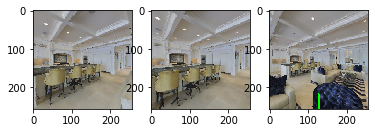

W0730 15:16:29.745144 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  19
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0001 0.0004 0.0011 0.0030 0.0081 0.0219 0.0596 0.1621 0.4406 0.8350 0.3072 0.1130 0.0416 0.0153 0.0056 0.0021 0.0008 0.0003 0.0001 


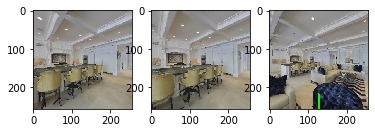

W0730 15:16:29.958668 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  20
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0004 0.0010 0.0027 0.0074 0.0200 0.0544 0.1478 0.4018 0.9156 0.3368 0.1239 0.0456 0.0168 0.0062 0.0023 0.0008 0.0003 


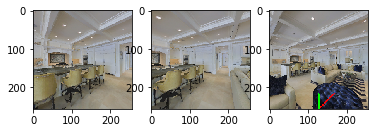

W0730 15:16:30.174201 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  22
0.0000 0.0000 0.0000 1.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0003 0.0009 0.0023 0.0064 0.0173 0.0469 0.1275 0.3467 0.9424 0.3904 0.1436 0.0528 0.0194 0.0071 0.0026 0.0010 


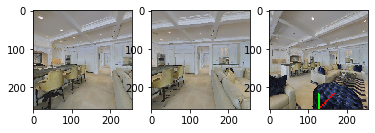

W0730 15:16:30.387192 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  23
0.0000 0.0000 0.0000 1.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0003 0.0008 0.0021 0.0058 0.0156 0.0425 0.1156 0.3143 0.8544 0.4306 0.1584 0.0583 0.0214 0.0079 0.0029 


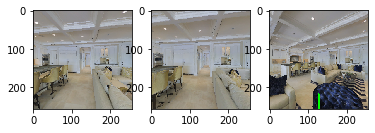

W0730 15:16:30.612702 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  24
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0003 0.0007 0.0020 0.0053 0.0144 0.0392 0.1065 0.2896 0.7872 0.4674 0.1719 0.0632 0.0233 0.0086 


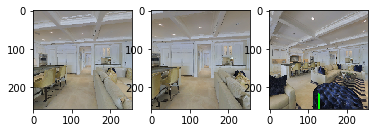

W0730 15:16:30.832849 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  25
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0002 0.0007 0.0018 0.0049 0.0132 0.0360 0.0978 0.2659 0.7228 0.5090 0.1872 0.0689 0.0253 


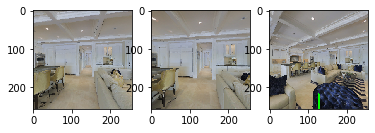

W0730 15:16:31.051137 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  26
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0002 0.0006 0.0017 0.0045 0.0123 0.0333 0.0905 0.2461 0.6689 0.5500 0.2023 0.0744 


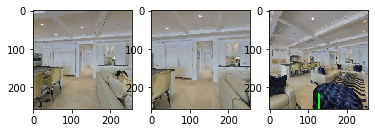

W0730 15:16:31.359313 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  27
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0002 0.0006 0.0015 0.0042 0.0114 0.0309 0.0840 0.2284 0.6208 0.5926 0.2180 


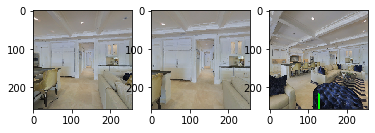

W0730 15:16:31.575627 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  28
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0002 0.0005 0.0015 0.0040 0.0110 0.0298 0.0811 0.2204 0.5991 0.6140 


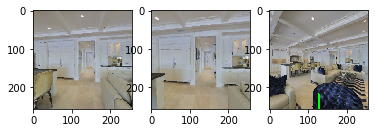

W0730 15:16:31.815766 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  29
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0003 0.0009 0.0025 0.0067 0.0183 0.0498 0.1353 0.3679 1.0000 


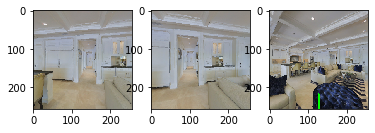

W0730 15:16:32.034481 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  29
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0003 0.0009 0.0025 0.0067 0.0183 0.0498 0.1353 0.3679 1.0000 


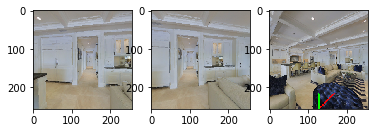

W0730 15:16:32.277898 140106295195392 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eta :  29
0.0000 0.0000 0.0000 1.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0003 0.0009 0.0025 0.0067 0.0183 0.0498 0.1353 0.3679 1.0000 


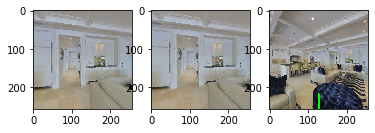

eta :  29
0.0000 1.0000 0.0000 0.0000 
0.0000 1.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0003 0.0009 0.0025 0.0067 0.0183 0.0498 0.1353 0.3679 1.0000 


IndexError: index 30 is out of bounds for axis 0 with size 30

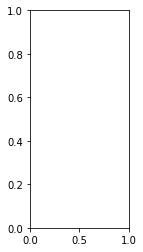

In [11]:
batch = load_data(valid_list[9])
demonstration = [np.expand_dims(batch[0],0), np.expand_dims(batch[1],0)]
rpf.reset()
rpf.encode_memory(sess,demonstration)
for t in range(max_follow_length):
    plt.subplot(131)
    demo_img = (batch[0][t]+1)/2.
    plt.imshow(demo_img)
    plt.subplot(132)
    demo_img = (batch[0][int(rpf.curr_eta)]+1)/2.
    ref_act = batch[1][t]
    if np.argmax(ref_act) == 1 : d_angle = 0 
    elif np.argmax(ref_act)== 2 : d_angle = 1
    elif np.argmax(ref_act)== 3 : d_angle = -1
    else : 
        d_angle = 0
        print('stop?')

    plt.imshow(demo_img)
    
    stop = 5
    if t > stop : 
        follow_img = (batch[2][stop]+1)/2.
        fol_act = rpf.predict_action(np.expand_dims(batch[2][stop],0)).squeeze()
    else : 
        follow_img = (batch[2][t]+1)/2.
        fol_act = rpf.predict_action(np.expand_dims(batch[2][t],0)).squeeze()
    if int(fol_act) == 1 : f_angle = 0 
    elif int(fol_act) == 2 : f_angle = 1
    elif int(fol_act) == 3 : f_angle = -1
    else : 
        f_angle = 0
        print('stop?')
    cv2.line(follow_img,(128,256),(int(128-40*d_angle),256-40),(255,0,0),3)
    cv2.line(follow_img,(128,256),(int(128-40*f_angle),256-40),(0,255,0),3)
                      
    plt.subplot(133)
    plt.imshow(follow_img)
    plt.show()
    
    print('eta : ', int(rpf.curr_eta))
    pprint(ref_act)
    pprint(np.eye(4)[int(fol_act)])
    pprint(np.stack([np.exp(-abs(rpf.curr_eta - float(j))) for j in range(demo_length)], 1).squeeze())

In [21]:
np.stack([np.exp(-abs(rpf.curr_eta - float(j))) for j in range(demo_length)], 1).squeeze()

array([1.61451325e-01, 4.38870221e-01, 8.38241994e-01, 3.08371991e-01,
       1.13443732e-01, 4.17336151e-02, 1.53529393e-02, 5.64803090e-03,
       2.07779440e-03, 7.64377823e-04, 2.81198765e-04, 1.03447244e-04,
       3.80561141e-05, 1.40000620e-05, 5.15033480e-06, 1.89470234e-06,
       6.97022017e-07, 2.56420066e-07, 9.43316749e-08, 3.47026834e-08,
       1.27664039e-08, 4.69649741e-09, 1.72774484e-09, 6.35601793e-10,
       2.33824848e-10, 8.60193514e-11, 3.16447528e-11, 1.16414534e-11,
       4.28265149e-12, 1.57549939e-12], dtype=float32)